# 0. Import Data

In [6]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import csv
import math
#import mplleaflet
import matplotlib.pyplot as plt
import pandas as pd
import gps_utils as gps
import time as ttt

current_milli_time = lambda: int(round(ttt.time() * 1000))

In [7]:
with open('../test.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    latitude_list = []
    longitude_list = []
    time_list = []
    # breaks only for development purposes
    counter = 0
    time = 0
    
    # for development only
    # test ist eine Liste mit allen Trajectories, jeder Traejctory ist ein (Pandas-) Dataframe mit den Spalten lon, lat, time
    test = []
    
    for row in csv_reader:
        cleared = row[8].replace("],[", " -1 ").replace("[[", "").replace("]]", "")
        if cleared != "POLYLINE":
            splitted = cleared.split(" -1 ")
            # extractes all the points
            for entry in splitted:
                data = entry.split(",")
                latitude_list.append(data[1])
                longitude_list.append(data[0])
                time_list.append(time)
                time += 15
            counter += 1
            time = 0
            # creats a trajectory dataframe
            coords = pd.DataFrame({'lon': longitude_list, 'lat': latitude_list, 'time': time_list})
            test.append(coords)
            # reset everything 
            latitude_list = []
            longitude_list = []
            time_list = []
            # breaks only for development purposes
            if counter == 35:
                break

FileNotFoundError: [Errno 2] No such file or directory: '../test.csv'

# 1. Initial Data 

In [ ]:
# retrieve the test route
coords = test[16]
coords.lon = coords.lon.astype(float)
coords.lat = coords.lat.astype(float)

In [ ]:
fig = plt.figure()
simplified_coords = coords[['lon', 'lat']].values
plt.plot(simplified_coords[:,0], simplified_coords[:,1])
plt.plot(simplified_coords[:,0], simplified_coords[:,1], 'ro')

In [ ]:
mplleaflet.display(fig=fig)

# 2. Trajectory Partition

## 2.1. Stop Point Extraction (TDBC)
Referenz: Z. Fu, Z. Tian, Y. Xu, and C. Qiao, ‘‘A two-step clustering approach to extract locations from individual GPS trajectory data,’’ ISPRS Int. J. Geo- Inf., vol. 5, no. 10, p. 166, 2016.

Auch bei Github hochgeladen als spe-tdbc.pdf

In [ ]:
def centroid(lonT, latT):
    # https://stackoverflow.com/questions/6671183/calculate-the-center-point-of-multiple-latitude-longitude-coordinate-pairs
    
    # lonT = [13.341664, 13.374373, 13.376003, 13.352830]
    # latT = [52.519198, 52.523039, 52.504053, 52.508498]
    
    '''
    benchmark beginns
    '''
    start_time = current_milli_time()
    
    
    if (len(lonT) == 0 or len(latT)== 0):
        return 0, 0

    xList = []
    yList = []
    zList = []

    dataT = pd.DataFrame({'lat': latT, 'lon': lonT})
    for index, row in dataT.iterrows():
        lat = row['lat'] * math.pi / 180
        lon = row['lon'] * math.pi / 180
        X = math.cos(lat) * math.cos(lon)
        Y = math.cos(lat) * math.sin(lon)
        Z = math.sin(lat)
        xList.append(X)
        yList.append(Y)
        zList.append(Z)

    dataXYZ = pd.DataFrame({'x': xList, 'y': yList, 'z': zList})

    x = 0
    y = 0
    z = 0
    n = 0

    for index, row in dataXYZ.iterrows():
        x += row['x']
        y += row['y']
        z += row['z']
        n += 1

    aX = x / n
    aY = y / n
    aZ = z / n

    Lon = math.atan2(y, x) * 180 / math.pi
    Hyp = math.sqrt(x * x + y * y)
    Lat = math.atan2(z, Hyp) * 180 / math.pi
    
    '''
    benchmark ends
    '''
    time = (current_milli_time() - start_time)
    print("----------centroid(...): BEGIN----------")
    print("time consumption in ms: {}".format(time))
    print("----------centroid(...): END----------")
    
    return Lon, Lat

In [ ]:
def stop_point_extraction(trajectory, time_threshold, distance_threshold):
    
    '''
    benchmark beginns
    '''
    start_time = current_milli_time()
    
    # leere Cluster, c_cluster ist Cluster aus dem Paper, p_cluster ist Previous C
    c_cluster = pd.DataFrame(columns=['lon', 'lat', 'time'])
    p_cluster = pd.DataFrame(columns=['lon', 'lat', 'time'])
    stop_points = pd.DataFrame(columns=['lon', 'lat', 'time'])
    stop_points_cluster = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
    # p_point ist Previous stop point in SP aus dem Paper, relevant für Zeile 9 und 11 aus dem Paper
    p_point = None
    c_point = None
    # Boolean Flag, nur relevant für die check Funktion
    is_type2 = False
    # braucht man nicht wirklich
    counter = 0

    def start_end(cluster):
        min_time = min(cluster['time'].tolist())
        max_time = max(cluster['time'].tolist())
        return min_time, max_time

    def add_stop_point(cluster):
        # print("-------------------BEGIN: add_stop_point(cluster)---------------------")
        # nonlocal, damit auf die Variablen der übergeordneten Funktion aufgerufen und bearbeiten werden kann
        nonlocal p_cluster
        nonlocal stop_points
        nonlocal stop_points_cluster
        nonlocal c_cluster
        # Variablen Initialisierung
        p_stop_point = None
        # Nur relevant für die Initailisierung des Algorithmuses: wenn kein Stopppunkt vorhanden,
        # füge das aktuelle Cluster oder Punkt der Liste der Stopppunkte hinzu
        # print("-> cluster:")
        # print(cluster)
        min_time, max_time = start_end(cluster)
        if len(stop_points.tail(1)['lon'].values) == 0:
            stop_points = stop_points.append(cluster, ignore_index=True)
            spc_frame = pd.DataFrame(
                {"lon": [cluster['lon'][0]], "lat": [cluster['lat'][0]], "tstart": [cluster['time'][0]]})
            stop_points_cluster = stop_points_cluster.append(spc_frame, ignore_index=True)
            p_cluster = cluster
            # print("--> initial SP")
            # print("-> stop_points:")
            # print(stop_points)
            # print("-> stop_points_cluster:")
            # print(stop_points_cluster)
        else:
            p_stop_point = stop_points_cluster.tail(1)['lon'].values[0], stop_points_cluster.tail(1)['lat'].values[0]
            cluster_coord = centroid(cluster['lon'].tolist(), cluster['lat'].tolist())
            # gps.haversine(coord1, coord2) berechnet die Distanc in Metern zwischen zwei Koordinaten
            # coord1 und coord2 müssen als Dataframe mit den Spalten lon und lat vorliegen
            # print("-> p_stop_point")
            # print(p_stop_point)
            # print("-> cluster")
            # print(cluster_coord)
            # print("-> distance between cluster and p_stop_point")
            # print(gps.haversine(cluster_coord, p_stop_point))
            if gps.haversine(cluster_coord, p_stop_point) < distance_threshold:
                # hängt alle Punkte des Clusters oder einzelnen Punkt an den p_cluster (vorheriger Cluster)
                p_stop_point_lon, p_stop_point_lat = p_stop_point
                test_point = centroid([p_stop_point_lon], [p_stop_point_lon])
                test_point_frame = pd.DataFrame(
                    {"lon": [p_stop_point_lon], "lat": [p_stop_point_lat], "tstart": [min_time], "tend": [max_time]})
                stop_points = pd.concat([stop_points, cluster]).drop_duplicates().reset_index(drop=True)
                stop_points_cluster = stop_points_cluster.drop(stop_points_cluster.tail(1).index, inplace=True)
                stop_points_cluster = pd.concat([stop_points_cluster, test_point_frame]).drop_duplicates().reset_index(
                    drop=True)
                # print("--> Added c_cluster to p_cluster!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                # print("-> c_cluster:")
                # print(c_cluster)
                # print("-> p_cluster:")
                # print(p_cluster)
                c_cluster = c_cluster.iloc[0:0]
            else:
                centeroid_lon, centeroid_lat = cluster_coord
                if centeroid_lon != 0:
                    data = {'lon': [centeroid_lon], 'lat': [centeroid_lat], 'tstart': [min_time], 'tend': [max_time]}
                    sp_frame = pd.DataFrame(data, columns=['lon', 'lat', 'tstart', 'tend'])
                    stop_points = stop_points.append(cluster, ignore_index=True)
                    stop_points_cluster = stop_points_cluster.append(sp_frame, ignore_index=True)
                    p_cluster = cluster
                    # Dataframe.iloc[0:0] löscht den Inhalt eines Dataframes, hier den Inhalt von c_cluster
                    c_cluster = c_cluster.iloc[0:0]
                    # print("---> p_cluster = cluster / drop c_cluster")
            # print("-> stop_points:")
            # print(stop_points)
            # print("-> stop_points_cluster:")
            # print(stop_points_cluster)
        # print("-------------------END: add_stop_point(cluster)---------------------")

    def check():
        # print("-------------------BEGIN: check()---------------------")
        nonlocal c_cluster
        nonlocal p_cluster
        nonlocal is_type2
        # centroid(coods, coords) berechnet den Mittelpunkt, Argumente, sind jeweils eine Liste von lon und lat
        c_cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        p_cluster_coord = centroid(p_cluster['lon'].tolist(), p_cluster['lat'].tolist())
        # print("---> BEFORE:")
        # print("-> c_cluster:")
        # print(c_cluster)
        # print("-> p_cluster:")
        # print(p_cluster)
        # print("-> time_interval:")
        # print(time_interval())
        # print("-> distance c_cluster_coord, p_cluster_coord:")
        # print(gps.haversine(c_cluster_coord, p_cluster_coord))
        if (time_interval() < time_threshold and gps.haversine(c_cluster_coord, p_cluster_coord) < distance_threshold):
            # p_cluster wird erweitert mit c_cluster, Duplikate werden gelöscht
            p_cluster = p_cluster.append(c_cluster).drop_duplicates().reset_index(drop=True)
            # print("-> p_cluster")
            # print(p_cluster)
            # print("-> is_type2")
            # print(is_type2)
            if is_type2 == True:
                # print("----> add_stop_point(p_cluster)")
                add_stop_point(p_cluster)
                is_type2 == False
                # c_cluster = c_cluster.iloc[0:0]
            else:
                # print("----> p_cluster = c_cluster / drop c_cluster")
                p_cluster = c_cluster
                # löschen des Inhalts von c_cluster
                # c_cluster = c_cluster.iloc[0:0]
        else:
            # pass
            add_stop_point(c_cluster)
        # print("---> AFTER:")
        # print("-> c_cluster:")
        # print(c_cluster)
        # print("-> p_cluster:")
        # print(p_cluster)
        # print("-------------------END: check()---------------------")

    def time_interval():
        nonlocal c_cluster
        nonlocal p_cluster
        # wenn p_cluster leer, dann return 0 als Zeitinterval
        if p_cluster.shape[0] == 0:
            return 0
        # berechnet den Zeitinterval von zwei Clustern, indem der Maximalwert (Zeit) der beiden Cluster - Minimalwert
        min_time = min([c_cluster.iloc[[0]]['time'].tolist()[0], p_cluster.iloc[[0]]['time'].tolist()[0]])
        max_time = max([c_cluster.iloc[[-1]]['time'].tolist()[0], p_cluster.iloc[[-1]]['time'].tolist()[0]])
        return abs(max_time - min_time)

    def duration():
        nonlocal c_cluster
        min_time = min(c_cluster['time'].tolist())
        max_time = max(c_cluster['time'].tolist())
        return max_time - min_time

    p_coord = None
    skip = False
    # adds the first and last trajectory points as type 1 stop points
    # if counter == 0 or counter == trajectory.shape[0]-1:

    first_sp_lon = trajectory.iloc[0].values[0]
    first_sp_lat = trajectory.iloc[0].values[1]
    first_sp_frame = pd.DataFrame({"lon": [first_sp_lon], "lat": [first_sp_lat], "time": [0]})
    # print(first_sp_frame)
    add_stop_point(first_sp_frame)
    for index, point in trajectory.iterrows():
        c_point = point
        point_coord = point['lon'], point['lat']
        point_frame = pd.DataFrame({"lon": [point['lon']], "lat": [point['lat']], "time": [point['time']]})
        # print("_____________________________________________________________________________")
        # print(point_frame)
        # print("-> p_coord:")
        # print(p_coord)
        # print("-> point_coord:")
        # print(point_coord)
        # if p_coord != None:
        # print("-> distance between p_coord and point_coord:")
        # print(gps.haversine(p_coord, point_coord))
        # Lösungsvorschlag, wenn der initiale Cluster leer ist, dann füge aktuellen Punkt hinzu
        cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        # # print(gps.haversine(cluster_coord, point_coord))
        # # print(cluster_coord, point_coord)
        # Punkte des Typ 2 sind der 1,2,3 Fall
        if c_cluster.shape[0] == 0:
            # print("IF -> Cluster empty")
            if p_coord != None and gps.haversine(p_coord, point_coord) < distance_threshold:
                # print("----->c_cluster empty: put current point in c_cluster")
                p_p_lon, p_p_lat = p_coord
                p_point_frame = pd.DataFrame({"lon": [p_p_lon], "lat": [p_p_lat], "time": [point['time'] - 15]})
                # if (point['time'] - 15) != 0 :
                c_cluster = c_cluster.append(p_point_frame)
                c_cluster = c_cluster.append(point_frame)
                cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
            else:
                skip = True
                # print("----->PASS -> p_coord None or distance between p_coord, point_coord < distance_threshold")

        else:
            skip = False
            # print("ELSE -> Cluster not empty and point may be added to cluster")
            if gps.haversine(cluster_coord, point_coord) < distance_threshold:
                # print(">>>case1: put in c_cluster")
                c_cluster = c_cluster.append(point_frame)
                cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
                is_type2 = True
        if (skip != True):
            # print("Other Cases:")
            # print("-> distance cluster_coord and point_coord")
            # print(gps.haversine(cluster_coord, point_coord))
            # print("-> duration()")
            # print(duration())
            if c_cluster.shape[0] != 0 and gps.haversine(cluster_coord,
                                                         point_coord) > distance_threshold and duration() > time_threshold:
                # print(">>>case2")
                add_stop_point(c_cluster)
                is_type2 = True
            if c_cluster.shape[0] != 0 and gps.haversine(cluster_coord,
                                                         point_coord) > distance_threshold and duration() < time_threshold:
                # print(">>>case3")
                check()
                is_type2 = True
            if p_coord != None and gps.haversine(p_coord, point_coord) < distance_threshold and 15 > time_threshold:
                # print(">>>case4")
                is_type2 = False

            if p_coord != None and gps.haversine(p_coord, point_coord) > distance_threshold and 15 > time_threshold:
                # print(">>>case5")
                is_type2 = False
                pass
        # print("<<<----------LOOP RESULTS BEGINN---------->>>")
        # print("-> c_cluster")
        # print(c_cluster)
        # print("-> p_cluster")
        # print(p_cluster)
        # print("-> END: stop_points")
        # print(stop_points)
        # print("-> END: stop_points_cluster")
        # print(stop_points_cluster)
        # print("<<<----------LOOP RESULTS END---------->>>")

        counter += 1
        # p_coord (Vorherige Punkt) wird gesetzt
        p_coord = point['lon'], point['lat']
    if c_cluster.shape[0] == 0:
        p_frame = {'lon': c_point['lon'], 'lat': c_point['lat'], 'time': c_point['time']}
        spc_frame = {"lon": c_point['lon'], "lat": c_point['lat'], "tstart": c_point['time']}
        # stop_points_cluster = stop_points_cluster.append(p_frame, ignore_index=True)
        stop_points = stop_points.append(p_frame, ignore_index=True)
        stop_points_cluster = stop_points_cluster.append(spc_frame, ignore_index=True)
    else:
        cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        centeroid_lon, centeroid_lat = cluster_coord
        min_time, max_time = start_end(c_cluster)
        data = {'lon': [centeroid_lon], 'lat': [centeroid_lat], 'tstart': [min_time], 'tend': [max_time]}
        sp_frame = pd.DataFrame(data, columns=['lon', 'lat', 'tstart', 'tend'])
        stop_points_cluster = stop_points_cluster.append(sp_frame, ignore_index=True)
        stop_points = stop_points.append(c_cluster, ignore_index=True)
    # print("ENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDEND")
    # print(stop_points_cluster)
    
    '''
    benchmark ends
    '''
    time = (current_milli_time() - start_time) 
    print("----------stop_point_extraction(...): BEGIN----------")
    print("time consumption in ms: {}".format(time))
    print("----------stop_point_extraction(...): END----------")

    return stop_points, stop_points_cluster

In [ ]:
time_threshold = 500
distance_threshold = 60
stop_points, stop_points_cluster = stop_point_extraction(coords, time_threshold, distance_threshold)

In [ ]:
'''
benchmark beginns
'''
start_time = current_milli_time()

new = coords.merge(stop_points,on=['lon','lat'],how='left')
new = new[new.time_y.isnull()]
new = new.rename(columns={"time_x": "tstart", "time_y": "tend"})
route = stop_points_cluster.append(new)
route = route.sort_values(by=['tstart']).reset_index(drop=True)

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------create_route: BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------create_route: END----------")

print(stop_points)
print(route)
polt_point_data = route[['lon', 'lat']].values
polt_stop_point_data = stop_points_cluster[['lon', 'lat']].values
plt.plot(polt_point_data[:,0], polt_point_data[:,1])
plt.plot(polt_point_data[:,0], polt_point_data[:,1], 'ro')
plt.plot(polt_stop_point_data[:,0], polt_stop_point_data[:,1], 's', color='red', markersize= 10)

## 2.2. Data Simplification 

In [ ]:
'''
benchmark beginns
'''
start_time = current_milli_time()

part = []
simplified_coords = pd.DataFrame(columns=['lon','lat','tstart', 'tend'])
counter = 0
for index, point in route.iterrows():
    counter += 1
    current_point = [point['lon'], point['lat']]
    part.append(current_point)
    if (not math.isnan(point['tend']) and len(part) > 1) or (route.shape[0] == counter) :
        l_data = gps.rdp(part, 0.00025)
        for i in l_data:
            l_lon = i[0]
            l_lat = i[1]
            l_frame = pd.DataFrame({"lon": [l_lon], "lat": [l_lat]})
            simplified_coords = simplified_coords.append(l_frame)
        part = []
        part.append(current_point)
#print(simplified_coords)
#simplified_coords = simplified_coords.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)
#print(simplified_coords)
merged = route.merge(simplified_coords, on=['lon','lat'])
merged = merged.drop(['tstart_y', 'tend_y'], axis=1)
merged = merged.rename(columns={'tstart_x': 'tstart', 'tend_x': 'tend'})
#print(merged)
#print("{} gps points simplified to {} points".format(route.shape[0], simplified_coords.shape[0]))

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------data_simplification(...): BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------data_simplification(...): END----------")

In [ ]:
fig = plt.figure()
simplified_coords_plot = simplified_coords[['lon', 'lat']].values
plt.plot(simplified_coords_plot[:,0], simplified_coords_plot[:,1])
plt.plot(simplified_coords_plot[:,0], simplified_coords_plot[:,1], 'ro')
plt.plot(polt_stop_point_data[:,0], polt_stop_point_data[:,1], 's', color='red', markersize= 10)

In [8]:
mplleaflet.display(fig=fig)

NameError: name 'mplleaflet' is not defined

## 2.3. CSV Writer

In [9]:
'''
benchmark beginns
'''
start_time = current_milli_time()

p_point = pd.Series([])
p_point_e = False
header = False
lts = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing'])
for index, point in merged.iterrows():
    if p_point_e == False:
        pass
    else:
        # # print(point)
        brng = gps.bearingCalculator((p_point['lon'], p_point['lat']), (point['lon'], point['lat']))
        dis = gps.haversine((p_point['lon'], p_point['lat']), (point['lon'], point['lat']))
        lts_frame = pd.DataFrame(
            {'lon1': [p_point['lon']], 'lat1': [p_point['lat']], 'tstart1': [p_point['tstart']],
            'tend1': [p_point['tend']],
                 'lon2': [point['lon']], 'lat2': [point['lat']], 'tstart2': [point['tstart']], 'tend2': [point['tend']],
                 'distance': [dis], 'bearing': [brng]})
        lts = lts.append(lts_frame)
        # print(p_point, point)
        # print(brng, dis)
        p_point = point
        p_point_e = True

lts = lts.reset_index(drop=True)
    # print(lts)
if header == False:
    header = True
    lts.to_csv('test_lts.csv', header=True, sep=';', mode='w')  # header = 'False', index = 'True')
else:
    lts.to_csv('test_lts.csv', header=False, sep=';', mode='a')  # header = 'False', index = 'True')

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------write_to_csv(...): BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------write_to_csv(...): END----------")



NameError: name 'merged' is not defined

## 2.4. Common  Segment  Discovery 

### alternative 

In [10]:
import numpy as np
global line_segments

line_segments = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route'])
with open('test_lts.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    route_id = 0 
    for row in csv_reader:
        if row[0] == '':
            pass
        else:
            if float(row[0]) == 0:
                route_id += 1
            # a short line segment might induce over-clustering, thus a the partitioning criteria is added
            if float(row[9]) >= 25:
                df = {'lon1': float(row[1]), 'lat1': float(row[2]), 'tstart1': float(row[3]), 'tend1': row[4],
                      'lon2': float(row[5]), 'lat2': float(row[6]), 'tstart2': float(row[7]), 'tend2': row[8],
                      'distance': row[9], 'bearing': row[10], 'route': route_id}
                line_segments = line_segments.append(df, ignore_index=True)
                


In [11]:
'''
Input: Zwei Linien als Pandas Series
Output: Die längere Line zuerst, dann die kürzere Line als Pandas Series
'''
def longer_and_shorter_lines(line_a, line_b):
    if line_a['distance'] > line_b['distance']:
        return (line_b, line_a)
    else:
        return (line_a, line_b)

#### test of projection points ps and pe

[-0.0011115 -0.001215 ]
[-0.0011115 -0.001215 ]
[-8.5867875 41.147307 ]
[-8.58626091 41.14788262]
-0.3857035655745071


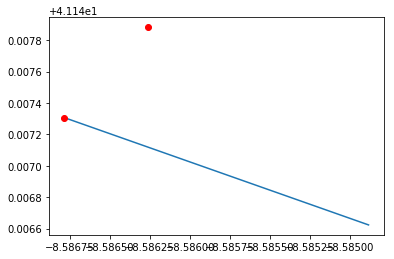

In [12]:
'''
Zum Testen und visualisieren der projection points Funktion
Eventuell muss Exception Handling eingebaut werden
'''

si = [-8.585676, 41.148522] 
ei = [-8.586787499506492, 41.14730700019343]
sj = [-8.586787499506492, 41.14730700019343]
ej = [-8.584884, 41.146623]

# ps
sisj = np.array([sj[0] - si[0], sj[1] - si[1]])
siei = np.array([ei[0] - si[0], ei[1] - si[1]])
print(sisj)
print(siei)
siei_norm = np.linalg.norm(siei)
u1 = np.dot(sisj, siei) / (siei_norm * siei_norm)
ps = si + u1 * siei
print(ps)

# pe
siej = np.array([ej[0] - si[0], ej[1] - si[1]])
u2 = np.dot(siej, siei) / (siei_norm * siei_norm)
pe = si + u2 * siei
print(pe)

# angle θ
sjej = np.array([ej[0] - sj[0], ej[1] - sj[1]])
cos_angle = np.dot(siei, sjej) / (np.linalg.norm(siei) * np.linalg.norm(sjej))
print(cos_angle)

fig = plt.figure()
# plt.plot([si[0], ei[0]], [si[1], ei[1]])
plt.plot([sj[0], ej[0]], [sj[1], ej[1]])
plt.plot(ps[0] , ps[1], 'ro')
plt.plot(pe[0] , pe[1], 'ro')
plt.show()

In [13]:
mplleaflet.display(fig=fig)

NameError: name 'mplleaflet' is not defined

#### real implementation of projection points ps and pe function

In [15]:
def projection_points(line_a, line_b):
    '''
    si = [13.323899, 52.512749]
    ei = [13.332428,  52.513389]
    sj = [13.325390,  52.513223]
    ej = [13.328577,  52.514398]
    '''
    si = line_a['si']
    ei = line_a['ei']
    sj = line_b['sj']
    ej = line_b['ej']
    
    # ps
    sisj = np.array([sj[0] - si[0], sj[1] - si[1]])
    siei = np.array([ei[0] - si[0], ei[1] - si[1]])
    siei_norm = np.linalg.norm(siei)
    u1 = np.dot(sisj, siei) / (siei_norm * siei_norm)
    ps = si + u1 * siei
    
    # pe
    siej = np.array([ej[0] - si[0], ej[1] - si[1]])
    u2 = np.dot(siej, siei) / (siei_norm * siei_norm)
    pe = si + u2 * siei

    # angle θ
    sjej = np.array([ej[0] - sj[0], ej[1] - sj[1]])
    cos_angle = np.dot(siei, sjej) / (np.linalg.norm(siei) * np.linalg.norm(sjej))
        
    return (pe, ps, cos_angle)


#### distance functions

In [16]:
def distance_functions(line_a, line_b):
    '''
    si = [13.323899, 52.512749]
    ei = [13.332428,  52.513389]
    sj = [13.325390,  52.513223]
    ej = [13.328577,  52.514398]
    '''
    si = line_a['si']
    ei = line_a['ei']
    sj = line_b['sj']
    ej = line_b['ej']
    
    '''
    if (si == sj and ei == ej) or (si == ei or sj == ej):
        return 0
    '''
    
    pe, ps, cos_angle = projection_points(line_a, line_b)
    
    def perpendicular_distance(line_a, line_b):
        l1 = np.linalg.norm(ps-sj)
        l2 = np.linalg.norm(pe-ej)
        dist = (l1*l1+l2*l2)/l1+l2
        return dist

    def parallel_distance(line_a, line_b):
        l1 = min(np.linalg.norm(si-ps), np.linalg.norm(ei-ps))
        l2 = min(np.linalg.norm(si-pe), np.linalg.norm(ei-pe))
        dist = min(l1, l2)
        return dist

    def angle_distance(line_a, line_b):
        nonlocal cos_angle
        if (cos_angle) > 1:
            cos_angle = 1
        angle = math.acos(cos_angle)
        sjej = np.array([ej[0] - sj[0], ej[1] - sj[1]])
        dist = 0
        # print("angle: {}".format(np.degrees(angle)))
        if np.degrees(angle) >= 0 and np.degrees(angle) < 90:
            dist = np.linalg.norm(sjej) * math.sin(angle)
        elif np.degrees(angle) >= 90 and np.degrees(angle) <= 180:
            dist = np.linalg.norm(sjej)
        return dist

    perpendicular_distance = perpendicular_distance(line_a, line_b)
    parallel_distance = parallel_distance(line_a, line_b)
    angle_distance = angle_distance(line_a, line_b)
    
    # print("perpendicular_distance: {}".format(perpendicular_distance))
    # print("parallel_distance: {}".format(parallel_distance))
    # print("angle_distance: {}".format(angle_distance))
    
    '''
    Per Diffinition ist die Distanz die Addierte Distanzen der verschiedenen Funktionen,
    eine Gewichting kann noch erfolgen falls notwendig
    '''
    
    return (perpendicular_distance + parallel_distance + angle_distance)
    
    
    

### Algorithm Line Segment Clustering Implementation 

In [17]:
'''
Berechnet die Nachbarschaft indem die Distanz der Input Line mit allen anderen Linien verglichen wird:
The ε-neighborhood Nε(Li) of a line segment Li ∈DisdefinedbyNε(Li)={Lj ∈D|dist(Li,Lj)≤ε
'''
# Compute Nε(L);
def neighborhood(line, cluster_id, extended): 
    neighbors = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
    for entry in line_segments.iterrows():
        is_classified = entry[1]['classified']
        
        if (not extended and is_classified < 0) or extended:    
            if not line[1].equals(entry[1]):
                line_longer, line_shorter = longer_and_shorter_lines(line[1], entry[1])
                line_a = {'si': [line_longer[0], line_longer[1]], 'ei': [line_longer[4], line_longer[5]]}
                line_b = {'sj': [line_shorter[0], line_shorter[1]], 'ej': [line_shorter[4], line_shorter[5]]}
                '''
                Parameter ε ist aktuell 0.0005
                '''
                if distance_functions(line_a, line_b) < 0.0005:
                    # line_segments.set_value(entry[0],'classified',cluster_id)
                    neighbors = neighbors.append(entry[1])
    return neighbors
    

In [18]:
# /* Step 2: compute a density-connected set */
def expand_cluster(queue, cluster_id):
    global line_segments
    # print("----------------input queue start----------------")
    # print(queue)
    # print("----------------input queue ended----------------")
    cluster = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
    while queue.shape[0] != 0:
        neighbors = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
        for entry in queue.iterrows():
            # Let M be the first line segment in Q;
            m = entry
            break
        # Compute Nε(M);
        neighbors = neighbors.append(neighborhood(m, cluster_id, True))
        neighbor_count = neighbors.shape[0] + 1
        # if (|Nε(M)| ≥ MinLns) then
        if (neighbor_count >= 3):
            for xn in neighbors.iterrows():
                #if (X is unclassified or noise) then
                if xn[1]['classified'] == -1 or xn[1]['classified'] == -2:
                    # line_segments.set_value(xn[0], 'classified', cluster_id)
                    # Assign clusterId to X;
                    line_segments.at[xn[0],'classified'] = cluster_id
                    series = pd.Series({'lon1': float(xn[1][0]), 'lat1': float(xn[1][1]), 'tstart1': float(xn[1][2]), 'tend1': xn[1][3],
                          'lon2': float(xn[1][4]), 'lat2': float(xn[1][5]), 'tstart2': float(xn[1][6]), 'tend2': xn[1][7],
                          'distance': xn[1][8], 'bearing': xn[1][9], 'route': xn[1][10], 'classified': cluster_id})
                    series.name = xn[0]
                    cluster = cluster.append(series)
                # if (X is unclassified) then
                if xn[1]['classified'] == -1:
                    # Insert X into the queue Q;
                    series = pd.Series({'lon1': float(xn[1][0]), 'lat1': float(xn[1][1]), 'tstart1': float(xn[1][2]), 'tend1': xn[1][3],
                          'lon2': float(xn[1][4]), 'lat2': float(xn[1][5]), 'tstart2': float(xn[1][6]), 'tend2': xn[1][7],
                          'distance': xn[1][8], 'bearing': xn[1][9], 'route': xn[1][10], 'classified': cluster_id})
                    series.name = xn[0]
                    queue = queue.append(series)
        # Remove M from the queue Q;
        queue = queue.iloc[1:]
        
        # print("----------------output queue start----------------")
        # print(queue)
        # print("----------------output queue ended----------------")
        
    # print("_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")
    # print(cluster)
    # print("_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")
    return cluster
        
    

In [19]:
'''
benchmark beginns
'''
start_time = current_milli_time()

global line_segments

np.seterr(invalid='ignore', divide='ignore')
# /* Step 1 */
# Set clusterId to be 0; /* an initial id */
cluster_id = 0
line_segments['classified'] = -1
neighbors = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
queue = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
clusters = []

'''
die Spalte classified der Dataframes kann folgende Werte besitzen:
-1 := unclassified
-2 := noise
>= 0 := die entsprechende Segmente (Cluster)

Output dieser Zelle:
1.) Modifiziertes Dataframe der line_segments (Ausgangsdaten der test_lts.csv) mit der Routennummer und classified Status
2.) cluster: eine Liste mit Dataframes, die die Segmente (Cluster) darstellen
'''

for entry in line_segments.iterrows():
    entry = (entry[0], line_segments.loc[[entry[0]]].iloc[0])
    is_classified = entry[1]['classified']
    if is_classified == -1:
        # Compute Nε(L);
        neighbors = neighbors.append(entry[1])
        neighbors = neighbors.append(neighborhood(entry, cluster_id, False))
        neighbor_count = neighbors.shape[0]
        '''
        Parameter MinLns ist aktuell 3
        '''
        if neighbor_count >= 3:
            # Assign clusterId to ∀X ∈ Nε(L);
            neighbors['classified'] = cluster_id
            # line_segments.set_value(entry[0], 'classified' , cluster_id)
            line_segments.at[entry[0],'classified'] = cluster_id
            # Insert Nε(L) − {L} into the queue Q;
            queue = queue.append(neighbors.tail(neighbor_count - 1))
            # /* Step 2 */
            neighbors = neighbors.append(expand_cluster(queue, cluster_id))
            # print("????????????????????????????")
            # print(neighbors)
            # print("????????????????????????????")
            for index in neighbors.index.values.tolist():
                line_segments.set_value(index, 'classified' , cluster_id)
            neighbors.drop_duplicates(keep='first', inplace=True)
            '''
            clusters ist eine Liste mit allen Linien eines gemeinsamen Segments
            '''
            clusters.append(neighbors)
            # Increase clusterId by 1; /* a new id */
            cluster_id += 1
        else:
            # Mark L as noise;
            # line_segments.set_value(entry[0],'classified', -2)
            line_segments.at[entry[0],'classified'] = -2
            if entry[0] == 4:
                print("What should i do? First")
                
    neighbors = neighbors.iloc[0:0]
    queue = queue.iloc[0:0]
    
    '''
    Aktuell auf 4 Segmente (Cluster) beschränkt (aus Testzwecken / Performance)
    '''
    if cluster_id == 4:
        break

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------Line Segment Clustering: BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------Line Segment Clustering: END----------")


----------Line Segment Clustering: BEGIN----------
time consumption in ms: 90289
----------Line Segment Clustering: END----------


In [20]:
# /* Step 3 */
# /* check the trajectory cardinality */

final_cluster = []

for segment in clusters:
    print(segment.route.nunique())
    '''
    Parameter MinLns ist aktuell 3
    '''
    # if (|PTR(C)| < MinLns) then
    if segment.route.nunique() >= 3:
        # Remove C from the set O of clusters;
        final_cluster.append(segment)
        
print("----")
for segment in final_cluster:
    print(segment.route.nunique())

5
12
5
4
----
5
12
5
4


#### data comparison

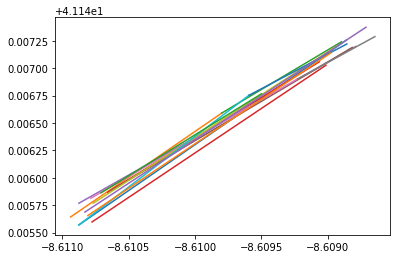

----------cluster via search: BEGIN----------
time consumption in ms: 595
----------cluster via search(...): END----------


In [21]:
'''
benchmark beginns
'''
start_time = current_milli_time()

fig = plt.figure()
for entry in line_segments.iterrows():
    '''
    Das Ändern der 1 in der if-Abfrage, ändert das Testcluster 
    '''
    if entry[1]['classified'] == 1:        
        # plot
        lon = [entry[1][0], entry[1][4]]
        lat = [entry[1][1], entry[1][5]]
        plt.plot(lon, lat)
plt.show()

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------cluster via search: BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------cluster via search(...): END----------")

          lon1       lat1  tstart1  tend1      lon2       lat2  tstart2  \
2    -8.610876  41.145570      0.0   30.0 -8.608857  41.147259     75.0   
301  -8.610939  41.145642      0.0   45.0 -8.609798  41.146592     60.0   
302  -8.609798  41.146592     60.0  105.0 -8.608896  41.147242    120.0   
1972 -8.610633  41.145885      0.0        -8.608815  41.147190     30.0   
2099 -8.610768  41.145768      0.0   30.0 -8.608934  41.147201     45.0   
2282 -8.609594  41.146754     60.0   75.0 -8.608856  41.147222     90.0   
3272 -8.610809  41.145656    315.0  330.0 -8.608978  41.147139    360.0   
3315 -8.610777  41.145597      0.0        -8.609013  41.147028     30.0   
3531 -8.610831  41.145687      0.0   15.0 -8.608712  41.147375     45.0   
2281 -8.610876  41.145570      0.0   30.0 -8.609594  41.146754     60.0   
1467 -8.610660  41.145867      0.0        -8.609063  41.147060     15.0   
3302 -8.610710  41.145863      0.0   15.0 -8.609499  41.146767     30.0   
1470 -8.610876  41.145768

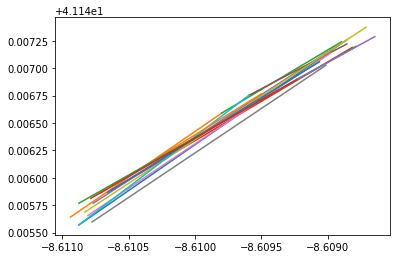

----------cluster via list: BEGIN----------
time consumption in ms: 336
----------cluster via list: END----------


In [22]:
'''
benchmark beginns
'''
start_time = current_milli_time()

fig = plt.figure()
counter = 0
for entry in clusters:
    '''
    Das Ändern der 1 in der if-Abfrage, ändert das Testcluster 
    '''
    if counter == 1:
        print(entry)
        for data in entry.iterrows():
            # plot
            lon = [data[1][0], data[1][4]]
            lat = [data[1][1], data[1][5]]
            plt.plot(lon, lat)
    counter += 1
plt.show()

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------cluster via list: BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------cluster via list: END----------")

In [ ]:
mplleaflet.display(fig=fig)

### Representative Trajectory Generation

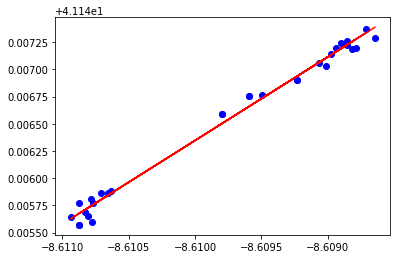

In [23]:
'''
simple linear regression 
'''

from sklearn.linear_model import LinearRegression


counter = 0

for entry in clusters:
    '''
    Das Ändern der 1 in der if-Abfrage, ändert das Testcluster 
    '''
    if counter == 1:
        lon1_list = entry['lon1'].values.tolist()
        lon2_list = entry['lon2'].values.tolist()
        lon1_list.extend(lon2_list)
        x_list = np.array(lon1_list).reshape(-1, 1)
        lat1_list = entry['lat1'].values.tolist()
        lat2_list = entry['lat2'].values.tolist()
        lat1_list.extend(lat2_list)
        y_list = np.array(lat1_list).reshape(-1, 1)
        
        linear_regressor = LinearRegression()  # create object for the class
        linear_regressor.fit(x_list, y_list)  # perform linear regression
        Y_pred = linear_regressor.predict(x_list)  # make predictions

        fig = plt.figure()
        plt.plot(x_list, y_list, 'bo')
        plt.plot(x_list, Y_pred, color='red')
        plt.show()
    counter += 1


In [24]:
mplleaflet.display(fig=fig)

NameError: name 'mplleaflet' is not defined

In [53]:
'''
Schreibt das modifizierte Dataframe der line_segments in eine neue CSV (test_seg.csv)
'''



'''
benchmark beginns
'''
start_time = current_milli_time()

print(line_segments)
# line_segments.to_csv('test_seg.csv', header=True, sep=';', mode='w')  # header = 'False', index = 'True')

inputSP = ''
eins = ' -1 '
zwei = '-2\n'
route = 2
for entry in line_segments.iterrows():
    if( entry[1]['route'] == route):
        cluster = str(entry[1]['classified'])
        inputSP = inputSP + cluster
        inputSP = inputSP + eins
        #print('if:' + cluster + 'String: ' + inputSP)
    else:
        route += 1
        cluster = str(entry[1]['classified'])
        inputSP = inputSP + zwei + cluster + eins
        #print('else:' + cluster + 'String: ' + inputSP)
        
print(inputSP)        
        
        #.join(['num' for num in xrange(loop_count)])


'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------write_to_csv(...): BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------write_to_csv(...): END----------")



          lon1       lat1  tstart1  tend1      lon2       lat2  tstart2  \
0    -8.585676  41.148522      0.0   90.0 -8.586787  41.147307    120.0   
1    -8.586787  41.147307    120.0  135.0 -8.584884  41.146623    150.0   
2    -8.610876  41.145570      0.0   30.0 -8.608857  41.147259     75.0   
3    -8.608857  41.147259     75.0  105.0 -8.608179  41.148348    120.0   
4    -8.608179  41.148348    120.0  150.0 -8.607366  41.149920    180.0   
5    -8.607366  41.149920    180.0  210.0 -8.606358  41.151915    240.0   
6    -8.606358  41.151915    240.0        -8.604981  41.153319    270.0   
7    -8.604981  41.153319    270.0        -8.604805  41.154359    285.0   
8    -8.604805  41.154359    285.0  300.0 -8.604371  41.160652    375.0   
9    -8.604371  41.160652    375.0  420.0 -8.604120  41.161242    435.0   
10   -8.604120  41.161242    435.0  525.0 -8.603910  41.162049    540.0   
11   -8.603910  41.162049    540.0        -8.602740  41.162972    555.0   
12   -8.602740  41.162972

### ----------------------------------------------------------------------------------------------------------------------------------

In [ ]:
routes = []
points = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
p_points = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
with open('test_lts.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    header = True
    p_index = -1
    for row in csv_reader:
        #polt_point_data = route[['lon', 'lat']].values
        if header == True:
            header = False
        else:
            if p_index >= 0 and int(row[0]) == 0:
                p_points = p_points.append(df_alt, ignore_index=True)
                routes.append(p_points)
                points = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
            df = {'lon': float(row[1]), 'lat': float(row[2]), 'tstart': float(row[3]), 'tend': row[4]}
            df_alt = {'lon': float(row[5]), 'lat': float(row[6]), 'tstart': float(row[7]), 'tend': row[8]}
            points = points.append(df, ignore_index=True)
            p_index = int(row[0])
            p_points = points

In [ ]:
fig = plt.figure()
counter = 0
for test in routes:
    
    plot = test[['lon', 'lat']].values
    plt.plot(plot[:,0], plot[:,1])
    plt.plot(plot[:,0], plot[:,1], 'ro', markersize=3)
    counter += 1
plt.show()

In [ ]:
mplleaflet.show(fig=fig)

### 2.4.3. Segment

#### testdata and ploting

In [ ]:
l1_lon = [13.333203, 13.323440]
l1_lat = [52.513379, 52.512739]
r4_lon = [13.323687, 13.324814, 13.325855]
r4_lat = [52.512674, 52.512680, 52.512876]
r2_lon = [13.333053, 13.329931, 13.329727, 13.327174, 13.325543]
r2_lat = [52.513470, 52.513235, 52.513052, 52.512876, 52.513020]
r3_lon = [13.327722, 13.330393, 13.331648, 13.333343]
r3_lat = [52.513202, 52.513000, 52.513209, 52.513777]

In [ ]:
fig = plt.figure()
plt.plot(l1_lon, l1_lat)
plt.plot(r2_lon, r2_lat)
plt.plot(r3_lon, r3_lat)
plt.plot(r4_lon, r4_lat)
plt.plot(l1_lon, l1_lat, 'ro')
plt.plot(r2_lon, r2_lat, 'ro')
plt.plot(r3_lon, r3_lat, 'ro')
plt.plot(r4_lon, r4_lat, 'ro')


In [ ]:
mplleaflet.display(fig=fig)

#### building a Pandas data frame from the test data so it is a LG = {L1, L2,...,Ln}

In [ ]:
l1 = pd.DataFrame({'lon': l1_lon, 'lat': l1_lat})
r2 = pd.DataFrame({'lon': r2_lon, 'lat': r2_lat})
r3 = pd.DataFrame({'lon': r3_lon, 'lat': r3_lat})
r4 = pd.DataFrame({'lon': r4_lon, 'lat': r4_lat})
lg = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing'])
list_of_lg = [l1, r2, r3, r4]
p_p = None
for entry in list_of_lg:
    time = 0
    for c_p in entry.iterrows():
        if p_p != None and c_p[0] == 0:
            p_p = None
        if p_p != None:
            index = p_p[0]
            brng = gps.bearingCalculator((p_p[1][0], p_p[1][1]), (c_p[1][0], c_p[1][1]))
            dis = gps.haversine((p_p[1][0], p_p[1][1]), (c_p[1][0], c_p[1][1]))
            df = pd.DataFrame({
                'lon1': p_p[1][0], 
                'lat1': p_p[1][1], 
                'tstart1': time - 15, 
                'tend1': time, 
                'lon2': c_p[1][0], 
                'lat2': c_p[1][1], 
                'tstart2': time , 
                'tend2': time + 15, 
                'distance': dis, 
                'bearing': brng
            }, index=[index])
            lg = lg.append(df)
        p_p = c_p
        p_time = time
        time += 15
print(lg)

#### lines that belong to the same LTS in LG, are merged into one line, LG = {L,...,Lm,...,Lij}

In [ ]:
new_lg = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing'])
f_entry = None
p_entry = None
counter = 0
for entry in lg.iterrows():
    counter += 1
    if (entry[0] == 0 or lg.shape[0] == counter) and counter > 1:
        if lg.shape[0] == counter:
            p_entry = entry
        index = p_entry[0]
        brng = gps.bearingCalculator((f_entry[1][0], f_entry[1][1]), (p_entry[1][4], p_entry[1][5]))
        dis = gps.haversine((f_entry[1][0], f_entry[1][1]), (p_entry[1][4], p_entry[1][5]))
        df = pd.DataFrame({
                'lon1': f_entry[1][0], 
                'lat1': f_entry[1][1], 
                'tstart1': f_entry[1][2], 
                'tend1': f_entry[1][3], 
                'lon2': p_entry[1][4], 
                'lat2': p_entry[1][5], 
                'tstart2': p_entry[1][6] , 
                'tend2': p_entry[1][7], 
                'distance': dis, 
                'bearing': brng
            }, index=[index])
        f_entry = None
        new_lg = new_lg.append(df)
    if entry[0] == 0:
        f_entry = entry
    p_entry = entry
print(new_lg)

#### ploting after merging

In [ ]:
fig = plt.figure()
for i in new_lg.iterrows():
    lon_l = []
    lat_l= []
    p1_lon = i[1][0]
    p1_lat = i[1][1]
    lon_l.append(p1_lon)
    lat_l.append(p1_lat)
    p2_lon = i[1][4]
    p2_lat = i[1][5]
    lon_l.append(p2_lon)
    lat_l.append(p2_lat)
    plt.plot(lon_l, lat_l)
    plt.plot(lon_l, lat_l, 'ro')

In [ ]:
mplleaflet.display(fig=fig)

#### calculating the representative line of LG, Ax + By + C = 0
the angle θ is the mean angle in LG in:
$$\theta = \frac{1}{k}   \sum_{i=1}^{k} \theta_i, \theta \in [0, \pi)$$

In [ ]:
summe = 0
k = 0
for i in new_lg.iterrows():
    angle = i[1][9]
    k += 1
    if angle > 90 and angle <= 180:
        angle = 180 - angle
    elif angle > 180 :
        angle = 360 - angle
    print(i[1][9])
    print(angle)
    summe += angle
avg = (1 / k) * summe
print(avg)

##### the least squares straight line fitting is used to calculate the parameters of the representative line:
$$ C = \frac{1}{k} \sum_{i=1}^{k} ( -Ax_i - By_i), \begin{cases} A=1, B=0; \theta = \frac{\pi}{2} \\A = - tan \theta, B = 1; \theta  \neq \frac{\pi}{2} \end{cases} $$ 
where (x_i, y_i) is the endpoint of L_i in LG
$$ hint: \pi = 180 $$

In [ ]:
cc = 0
k = 0
a = 0
b = 0
for i in new_lg.iterrows():
    k += 1
    if (avg == 90):
        a = 1
        b = 0
    else:
        a = -math.tan(avg)
        b = 1
    x = i[1][4]
    y = i[1][5]
    print(a, b, x, y)
    cc += (-a * x - b * y)
    print(cc)
c = (1/k) * cc
print(a,b,c)

# Ax + By + C = 0 -> y = (-Ax - C) / B
def fun(xi):
    return (-a * xi - c) / b


##### plot of representative line of LG, Ax + By + C = 0

In [ ]:
fig = plt.figure()

for i in new_lg.iterrows():
    lon_l = []
    lat_l= []
    p1_lon = i[1][0]
    p1_lat = i[1][1]
    lon_l.append(p1_lon)
    lat_l.append(p1_lat)
    p2_lon = i[1][4]
    p2_lat = i[1][5]
    lon_l.append(p2_lon)
    lat_l.append(p2_lat)
    plt.plot(lon_l, lat_l)
    plt.plot(lon_l, lat_l, 'ro')
    
rl_lon_l = []
rl_lat_l = []
for i in new_lg.iterrows():
    p1_lon = i[1][0]
    p1_lat = fun(p1_lon)
    rl_lon_l.append(p1_lon)
    rl_lat_l.append(p1_lat)
    p2_lon = i[1][4]
    p2_lat = fun(p2_lon)
    rl_lon_l.append(p2_lon)
    rl_lat_l.append(p2_lat)
print(rl_lon_l)
print(rl_lat_l)
plt.plot(rl_lon_l, rl_lat_l)


In [ ]:
mplleaflet.display(fig=fig)

#### line projection
For each line L_i in LG, calculate the projection points of the endpoints on the representative line. ∀p(x_0 , y_0 ), the projection point on Ax + By + C = 0 can be calculated by:
$$ x' = (B^2 * x_0  - A*B*y_0 - A*C)/(A^2 +B^2) $$
$$ y' = (A^2 * y_0  - A*B*x_0 - B*C)/(A^2 +B^2) $$

In [14]:
for i in new_lg.iterrows():
    lon_l = []
    lat_l= []
    p1_lon = i[1][0]
    p1_lat = i[1][1]
    x = (b * b * p1_lon - a * b * p1_lat - a * c) / (a * a + b * b)
    y = (a * a * p1_lat - a * b * p1_lon - b * c) / (a * a + b * b)
    lon_l.append(x)
    lat_l.append(y)
    p2_lon = i[1][4]
    p2_lat = i[1][5]
    x = (b * b * p2_lon - a * b * p2_lat - a * c) / (a * a + b * b)
    y = (a * a * p2_lat - a * b * p2_lon - b * c) / (a * a + b * b)
    lon_l.append(x)
    lat_l.append(y)
    plt.plot(lon_l, lat_l)
    plt.plot(lon_l, lat_l, 'ro')

NameError: name 'new_lg' is not defined